In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

In [5]:
#verifico subito che importi il file, causa di errore più comune
imported_dataframe= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing/Time series simulated.csv", sep = ";")
print(imported_dataframe)

            Date       VTSIM      SPYSIM     VXUSSIM     GLDSIM     SHYSIM  \
0     03/01/2000   363024.65   456485.64   312227.52   22917.49   64327.31   
1     04/01/2000   352086.78   438635.96   305738.53   22226.61   64436.96   
2     05/01/2000   347231.97   439422.28   297085.70   22143.70   64358.88   
3     06/01/2000   344163.69   432361.79   292760.28   22060.80   64409.94   
4     07/01/2000   351764.33   457473.35   297522.70   22273.98   64472.72   
...          ...         ...         ...         ...        ...        ...   
6452  28/08/2025  1889394.90  3296256.53  1003068.28  269150.92  121287.99   
6453  29/08/2025  1879006.49  3276610.82   997844.32  271752.46  121390.39   
6454  02/09/2025  1865527.77  3252342.51   991312.49  278181.71  121329.49   
6455  03/09/2025  1872416.52  3269981.07   993499.24  280364.83  121417.53   
6456  04/09/2025  1885766.77  3297321.91   997429.77  279130.39  121505.58   

         IEFSIM     TLTSIM    ZROZSIM   KMLMSIM   DBMFSIM  
0  

In [3]:
#in caso di problemi con l'import del csv lanciare il blocco e copiare il percorso, ci sono spesso problemi coi caratteri
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive"
!ls "/content/drive/MyDrive/Colab Notebooks"
!ls "/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing"

Mounted at /content/drive
'Colab Notebooks'
'gold yf.ipynb'      'TBTFolio - testing'  'yfinance7 (1).ipynb'
'TBTFolio - backup'   VIX.ipynb		    yfinance7.ipynb
 Backtester.ipynb			'Time series simulated.csv'
'Tactical Allocation Backtester.ipynb'


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing"

 Backtester.ipynb			'Time series simulated.csv'
'Tactical Allocation Backtester.ipynb'


In [6]:
class portfolio:

    colonne_escluse = ["Date","DBMFSIM","KMLMSIM"]  # colonne da escludere nell'import del DF nell'oggetto
    # Asset da ribilanciare secondo la media mobile
    ma_rebalance    = [#"DBMFSIM",
                       "VTSIM",
                       #"VXUSSIM",
                       #"GLDSIM",
                       #"SPYSIM",
                       #"IEFSIM",
                       #"TLTSIM",
                       #"ZROZSIM",
                       #"KMLMSIM"
                       ]  # indici da ribilanciare secondo la media mobile

    # idici da ribilanciare secondo la strategia di ribilanciamento dei pesi
    w_rebalance     = []

    flag_w_rebalance = False  # mettere True per attivare la strategia di ribilanciamento dei pesi

    if (set(ma_rebalance) & set(w_rebalance)):  # check di indici con ribilanciamenti sovrapposti
        print("Sovrapposizione dei metodi di ribilanciamento")
        sys.exit()

    def __init__(self, initial_balance, transac_cost_rate, tax_rate, rebalance_threshold,
                 ma_window, ma_threshold, liquidity_asset, imported_dataframe, stock_price_normalization = True):
        if not isinstance(liquidity_asset, str):
            raise TypeError("Il liquidity asset deve essere definito come stringa.")

        self.TotValue                 = initial_balance         # Valore totale del PTF
        self.NetTotValue              = self.TotValue           # Valore totale del PTF sottraendo  tasse e costi di transazione
        self.transactional_cost_rate  = transac_cost_rate       # Percentuale costi di transazione
        self.TransactionalCost        = 0                       # Inizializzazione costo di transazione
        self.tax_rate                 = tax_rate                # Percentuale tassazione plusvalenza
        self.tax                      = 0                       # Inizializzazione tassa
        self.rebalance_threshold      = rebalance_threshold     # Soglia per effettuare il ribilanciamento dei pesi

        self.ma                       = pd.DataFrame()          # Media mobile
        self.ma_window                = ma_window               # Finestra temporale per il calcolo della media mobile
        self.ma_threshold             = ma_threshold            # Spread soglia della media mobile
        self.df                       = imported_dataframe      # DataFrame di input

        self.IndexName         = [                              # Set dei nomi degli asset in PTF
            col for col in self.df.columns
            if col not in self.colonne_escluse
        ]
        self.liquidity_asset = liquidity_asset         # Asset da utilizzare come liquidità quando si disinveste
        if self.liquidity_asset not in self.IndexName:
            raise TypeError("L'indice {} utilizzato per la liquidità non è presente nel dataset".format(self.liquidity_asset))
        # moving average calculation
        for stock in self.ma_rebalance:
            self.df[f"{stock}_ma"] = self.df[stock].rolling(window=self.ma_window).mean()

        # Prezzi iniziali che verranno utilizzati per la normalizzazione (memorizzato prima della pulizia)
        renorm_price = self.df.loc[0,self.IndexName]

        # moving average NaN cleaning
        cols_to_check = [strng + "_ma" for strng in self.ma_rebalance]
        first_valid_index = self.df[cols_to_check].notna().all(axis=1).idxmax()
        # 3. Filtra il DataFrame da quella riga in poi
        self.df = self.df.iloc[first_valid_index:].reset_index(drop=True).copy()

        if stock_price_normalization:                 # Inizializzazione prezzi degli asset (via normalizzazione o non)
            for strng_ma in self.ma_rebalance:
                self.ma[strng_ma] = self.df.loc[:,strng_ma + "_ma"]/renorm_price[strng_ma]
            self.StockPrice = self.df.loc[:,self.IndexName]/renorm_price[self.IndexName]

        else:
            self.ma[self.ma_rebalance]  = self.df
            self.StockPrice = self.df.loc[:,self.IndexName]

        #self.date                = pd.to_datetime(self.df['Date'], format = '%d/%m/%Y')                          # Date della serie storica
        self.date                = self.df['Date']

        self.initial_w           = pd.Series({"VTSIM":   1,  # TENERE ESCLUSI KMLMSIM E DBMFSIM
                                              "VXUSSIM": 0,
                                              "GLDSIM":  0,
                                              "SPYSIM":  0,
                                              "IEFSIM":  0,
                                              "TLTSIM":  0,
                                              "ZROZSIM": 0,
                                              #"KMLMSIM": 0,
                                              #"DBMFSIM": 0,
                                              "SHYSIM":  0
                                              })               # Setting pesi teorici
        if np.sum(self.initial_w) != 1:
            print("L'allocazione non somma a 1")
            sys.exit()
        if np.sum(self.initial_w > 0 ) != len(self.ma_rebalance):
            print('Allocazione pesi non corrispondente agli indici utilizzati per la strategia.')
            sys.exit()

        self.dynamic_w           = self.initial_w.copy()                                    # pesi da aggiornare dinamicamente
        self.ma_w                = self.initial_w.copy()                                    # Inizializzazione dei pesi che verranno utilizzati per ribilanciare con ma
        self.delta_notional      = pd.Series(data = 0, index = self.IndexName)
        self.invest_flag         = pd.Series(data = True, index = self.ma_rebalance)
        self.AssetValue          = self.TotValue*self.dynamic_w                                     # Inizializzazione valore degli asset in PTF
        self.PMC                 = pd.Series(data = self.StockPrice.loc[0,:], index = self.IndexName)*(self.initial_w != 0).reindex(self.StockPrice.columns)  # Inizializzazione Prezzo Medio di Carico (mettendo a 0 tutto quello cu cui non ho un investimento)
        self.plusval             = pd.Series(data = 0, index = self.IndexName)              # Inizializzazione plusvalenza
        self.notional            = self.AssetValue/self.StockPrice.loc[0,:]                 # Inizializzazione notional degli asset
        self.PMC_weight          = self.notional.copy()
        self.PercReturn          = 0                                                        # Inizializzazione rendimenti percentuali
        self.CompoundReturn      = 1                                                        # Inizializzazione rendimenti composti

    def update_TotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        self.TotValue = self.calculate_TotValue(StockPrice)

    def update_NetTotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        self.NetTotValue = self.calculate_NetTotValue(StockPrice)

    def update_AssetValue_weight(self,StockPrice):
        self.AssetValue = self.notional * StockPrice
        self.dynamic_w = self.AssetValue/self.calculate_TotValue(StockPrice)

    def calculate_TotValue(self,StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        return self.notional.dot(StockPrice)

    def calculate_NetTotValue(self, StockPrice):
        #StockPrice deve essere una Series col nome degli Stock come indici
        return self.calculate_TotValue(StockPrice) + self.TransactionalCost + self.tax

    def update_Return(self, StockPrice):
        old_NetTotValue = self.NetTotValue
        current_NetTotValue = self.calculate_NetTotValue(StockPrice)
        self.PercReturn = current_NetTotValue/old_NetTotValue - 1
        self.CompoundReturn *= 1 + self.PercReturn

    def update_PMC(self,StockPrice):
        mask_buy = self.delta_notional > 0
        self.PMC = self.PMC.copy()
        self.PMC[mask_buy] = (self.PMC[mask_buy]*self.PMC_weight[mask_buy]
                              + (self.delta_notional*StockPrice)[mask_buy] )
        self.PMC_weight[mask_buy] += self.delta_notional[mask_buy]
        self.PMC[mask_buy] /= self.PMC_weight[mask_buy]

    def update_tax(self,StockPrice):
        mask_tax = (self.delta_notional < 0) & (StockPrice > self.PMC)
        if np.sum(mask_tax) >0:
            self.plusval[mask_tax] = -(self.delta_notional*(StockPrice - self.PMC))[mask_tax]
            if sum(self.plusval[mask_tax] <= 0 ) > 0:
                print("Errore. Plusvalenza negativa")
            self.tax += -self.plusval.sum()*self.tax_rate
        #else:
        #    self.tax = 0

    def update_transactional_cost(self, StockPrice):
        self.TransactionalCost += -(abs(self.delta_notional)*StockPrice).sum()*self.transactional_cost_rate

    def update_notional_tax_transaccost(self, StockPrice):
        self.delta_notional = (self.ma_w - self.dynamic_w)*self.calculate_TotValue(StockPrice)/StockPrice
        self.update_PMC(StockPrice)
        self.update_tax(StockPrice)
        self.update_transactional_cost(StockPrice)
        mask_reset_PMC                  = (self.ma_w == 0)
        self.PMC[mask_reset_PMC]        = 0
        self.PMC_weight[mask_reset_PMC] = 0
        self.notional                  += self.delta_notional
        self.notional[mask_reset_PMC]   = 0

    def reset_tax_transaccost(self):
        self.tax = 0
        self.TransactionalCost = 0

    def reset_delta_notional(self):
        self.delta_notional[:] = 0

    def reset_plusval(self):
        self.plusval[:] = 0

    def check_rebalance(self,StockPrice,time):
        flag_rebalance = False
        for string in self.ma_rebalance:

            ma =  self.ma.loc[time,string]

            # sell
            if self.ma_w[string] > 0 and self.invest_flag[string] == True and StockPrice[string] < ma*(1-self.ma_threshold):
                self.ma_w[self.liquidity_asset] += self.ma_w[string]
                self.ma_w[string]                = 0
                self.invest_flag[string]         = False

                flag_rebalance = True

            # buy
            if self.ma_w[string] == 0 and self.invest_flag[string] == False and StockPrice[string] > ma*(1+self.ma_threshold):
                self.ma_w[self.liquidity_asset] -= self.initial_w[string]
                self.ma_w[string]                = self.initial_w[string]
                self.invest_flag[string]         = True

                flag_rebalance = True

            # weights rebalancing strategy
            if ptf.flag_w_rebalance == True and flag_rebalance == False and sum( np.abs(self.dynamic_w[self.w_rebalance] - self.ma_w[self.dynamic_w_rebalance]) > self.rebalance_threshold ) > 0:
                return True
        return flag_rebalance


/tmp/ipython-input-4141616550.py:142: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[np.float64(100.47598518375126)]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.plusval[mask_tax] = -(self.delta_notional*(StockPrice - self.PMC))[mask_tax]



Total compound return = 585.46%

Anni in simulazione = 24.9

CAGR = 7.36%


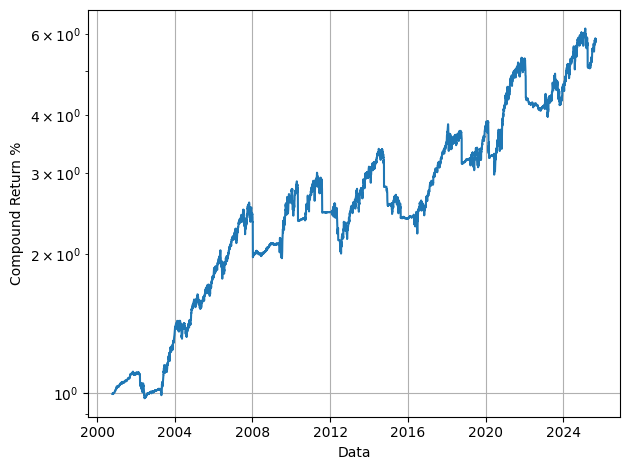

In [9]:
## RUN PRINCIPALE ##
# Import dataframe
path_data = "/content/drive/MyDrive/Colab Notebooks/TBTFolio - testing/Time series simulated.csv"

# Allocazione su indici di portafoglio:
# Index 1  # Index 2 # Index 3 # Index 4 ...

# df importing
df = pd.read_csv(path_data, parse_dates=["Date"], dayfirst=True, sep=";")
cols_to_check = df.columns.drop(["Date","DBMFSIM","KMLMSIM"])
first_valid_index = df[cols_to_check].notna().all(axis=1).idxmax()
# 3. Filtra il DataFrame da quella riga in poi
df_clean = df.iloc[first_valid_index:].reset_index(drop=True)

ptf = portfolio(initial_balance = 1000, transac_cost_rate= 0.0019, tax_rate = 0.26,
                rebalance_threshold = 0.05, ma_window= 200, ma_threshold= 0.03, imported_dataframe= df_clean,
                liquidity_asset = 'SHYSIM', stock_price_normalization= True)

df_log       = pd.DataFrame(index = ptf.date)
df_log_delta = pd.DataFrame(index = ptf.date)


for i in ptf.StockPrice.index:
    #ptf.reset_tax_transaccost()
    ptf.reset_delta_notional()
    ptf.reset_plusval()
    #ptf.ma_calculation(ptf.StockPrice, i)

    StockPrice = ptf.StockPrice.loc[i,:]
    ptf.update_AssetValue_weight(StockPrice)


    if ptf.check_rebalance(StockPrice, i):
        ptf.update_notional_tax_transaccost(StockPrice)

    ptf.update_Return(StockPrice)
    ptf.update_TotValue(StockPrice)
    ptf.update_NetTotValue(StockPrice)

    df_log.loc[ptf.date[i], "Return"]                                          = ptf.PercReturn
    df_log.loc[ptf.date[i], "Compound Return"]                                 = ptf.CompoundReturn
    df_log.loc[ptf.date[i], "TotValue"]                                        = ptf.TotValue
    df_log.loc[ptf.date[i], "NetTotValue"]                                     = ptf.NetTotValue
    df_log.loc[ptf.date[i], "Taxes"]                                           = ptf.tax
    df_log.loc[ptf.date[i], "TransacCost"]                                     = ptf.TransactionalCost

    for strng in ptf.IndexName:
        df_log.loc[ptf.date[i], strng]                     = ptf.StockPrice.loc[i,strng]
        if strng in ptf.ma.columns:
            df_log.loc[ptf.date[i], strng + "_ma"]         = ptf.ma.loc[i,strng]
        df_log.loc[ptf.date[i], strng + "_notional"]       = ptf.notional[strng]
        df_log.loc[ptf.date[i], strng + "_AssetValue"]     = ptf.AssetValue[strng]
        df_log.loc[ptf.date[i], strng + "_deltaNotional" ]           = ptf.delta_notional[strng]
        df_log.loc[ptf.date[i], strng + "_deltaAssetValue" ]         = ptf.delta_notional[strng]*StockPrice[strng]
        df_log.loc[ptf.date[i], strng + "_PMC"   ]         = ptf.PMC[strng]
        df_log.loc[ptf.date[i], strng + "_PlusVal"   ]     = ptf.plusval[strng]
    #df_log_delta.loc[ptf.date[i], ptf.IndexName]     = ptf.delta_notional*StockPrice

    if ptf.NetTotValue <= 0:
        print("Portafoglio di valore 0.")
        break

df_log.to_excel("output_ptf_ma.xlsx")
#ptf.df.to_excel("output_ptf_prices_ma.xlsx")
#df_log_delta.to_excel("output_ptf_delta_ma.xlsx")

print(f"\nTotal compound return = {ptf.CompoundReturn * 100:.2f}%")
years = round(((max(ptf.date) - min(ptf.date)).days / 365.25), 2)
print(f"\nAnni in simulazione = {years}")
print(f"\nCAGR = {(ptf.CompoundReturn**(1/years) -1) * 100:.2f}%")
plt.semilogy(df_log.index,df_log['Compound Return'])
plt.xlabel('Data')
plt.ylabel('Compound Return %')
#plt.title('Grafico')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()